# Cloudbutton geospatial use case: 3D fuel mapping for wildfire risk assessment


In [121]:
import pylab
# from sklearn.naive_bayes import GaussianNB
# from sklearn import model_selection
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import scale, StandardScaler
# from sklearn.metrics import silhouette_score
# from sklearn.cluster import KMeans
# from shapely.geometry import mapping
from IPython.display import Image
# from IPython.core.display import HTML
# from shapely.geometry import mapping
# import rasterio as rio
# from sklearn.pipeline import Pipeline
# from rasterio.mask import mask
# from rasterio.plot import show
# from rasterio.merge import merge
# from rasterio.plot import show
# from rasterio.plot import show_hist
# from rasterio.windows import Window
# from rasterio.plot import reshape_as_raster
# from rasterio.plot import reshape_as_image
from lithops.storage import Storage
import matplotlib.pyplot as plt
# import geopandas as gpd
import pandas as pd
import numpy as np
import lithops
import pathlib
# import shapely
import shutil
# import pickle
import subprocess
# import concurrent.futures
# import joblib
# import gdal
# import earthpy as ep
# import earthpy.spatial as es
import time
# import glob
# import ogr
import os
# import io
# import pdal
# import xarray as xr
import json
# from matplotlib.colors import ListedColormap, BoundaryNorm

In [122]:
DIR_TO_EXECT = "" # 20GB/10GB/2GB/1GB/512MB/256MB/128MB
DATA_BUCKET_SIZE = {'20GB': '20gb', '10GB': '10gb', '2GB': '2gb', '1GB': '1gb', '512MB':'512mb', '256MB': '256mb', '128MB': '128mb', 'test_size': 'optim-size'}
DATA_BUCKET = f'objects-geospatial-wildfirerisk-{DATA_BUCKET_SIZE["test_size"]}' # 'objects-geospatial-wildfirerisk-0'
INPUT_DATA_PREFIX = f'data-example/' # Modified

In [123]:
# !export LITHOPS_CONFIG_FILE = "/home/aitor/Projects/lithops-github/lithops/.lithops_config"
# os.environ['LITHOPS_CONFIG_FILE'] = '/home/aitor/Projects/lithops-github/lithops/.lithops_config'

Experiment parameters


In [124]:
FCC_WINDOW = 3
FCC_BREAKPOINT = 0.01

---
Upload dataset
---


In [125]:
LOCAL_INPUT_DIR = f'D:\data\laz_test_size' # f'./data_example/laz_test_size'

In [126]:
storage = Storage()

2022-06-05 23:20:35,040 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS client created - Region: eu-de


In [127]:
bucket_objects = storage.list_keys(bucket=DATA_BUCKET)
for file_name in os.listdir(LOCAL_INPUT_DIR):
    key = os.path.join(INPUT_DATA_PREFIX, file_name)  # Added
    if key not in bucket_objects:   # Changed: if file_name not in bucket_objects:
        with open(os.path.join(LOCAL_INPUT_DIR, file_name), 'rb') as file:
            print(f'Uploading {key}...')
            data = file.read()
            storage.put_object(bucket=DATA_BUCKET, key=key, body=data)
            print('Ok!')
    else:   # Added
        print(f'It is already uploaded: {key}...')   # Added

It is already uploaded: data-example/LIDARCATv02ls12f356556ed02.laz...
It is already uploaded: data-example/LIDARCATv02ls12f362554ed02.laz...
It is already uploaded: data-example/LIDARCATv02ls12f382584ed02.laz...
It is already uploaded: data-example/LIDARCATv02ls12f460612ed02.laz...
It is already uploaded: data-example/PNOA_2017_CLM-CAS_278-4470_ORT-CLA-RGB.laz...


---
Calculte DEM, DSM and CHM
---


In [128]:
def calculate_models(obj, storage):
    import pdal
    from osgeo import gdal
    from scipy import ndimage

    # Create temporary file paths
    tmp_path_prefix = '/tmp/geo/'
    if os.path.exists(tmp_path_prefix):
        shutil.rmtree(tmp_path_prefix)
    for subpath in ['dsm', 'dem', 'chm', 'aspect', 'slope', 'fcc']:
        os.makedirs(os.path.join(tmp_path_prefix, subpath), exist_ok=True)

    las_tile_filename = pathlib.Path(obj.key).name
    tile_key = pathlib.Path(obj.key).stem

    # Save obj to file
    data = obj.data_stream.read()
    input_file_path = os.path.join(tmp_path_prefix, las_tile_filename)
    with open(input_file_path, 'wb') as file:
        file.write(data)

    # DSM pipeline
    dsm_file_path = os.path.join(tmp_path_prefix, 'dsm', tile_key + '.gtiff')
    dsm_pipeline_json = {
        "pipeline": [
            {
                "type": "readers.las",
                "filename": f"{input_file_path}",
                "spatialreference": "EPSG:25830"
            },
            {
                "type": "filters.reprojection",
                "in_srs": "EPSG:25830",
                "out_srs": "EPSG:25830"
            },
            {
                "type": "filters.outlier",
                "method": "radius",
                "radius": 1.0,
                "min_k": 4
            },
            {
                "type": "filters.range",
                # Classification equals 2 (corresponding to noise points in LAS).
                "limits": "Classification![7:7]"
            },
            {
                "type": "filters.range",
                "limits": "returnnumber[1:1]"
            },
            {
                "type": "writers.gdal",
                "gdaldriver": "GTiff",
                "nodata": "-9999",
                "output_type": "max",
                "resolution": 1,
                "filename": f"{dsm_file_path}"
            }
        ]
    }
    dsm_pipeline_json_str = json.dumps(dsm_pipeline_json, indent=4)
    pipeline = pdal.Pipeline(dsm_pipeline_json_str)
    pipeline.validate()
    pipeline.loglevel = 8
    print('Executing DSM pipeline...')
    result = pipeline.execute()
    print(result)

    # DEM pipeline
    dem_file_path = os.path.join(tmp_path_prefix, 'dem', tile_key + '.gtiff')
    dem_pipeline_json = {
        "pipeline": [
            {
                "type": "readers.las",
                "filename": f"{input_file_path}",
                "spatialreference": "EPSG:25830"
            },
            {
                "type": "filters.reprojection",
                "in_srs": "EPSG:25830",
                "out_srs": "EPSG:25830"
            },
            {
                "type": "filters.assign",
                "assignment": "Classification[:]=0"
            },
            {
                "type": "filters.elm"
            },
            {
                "type": "filters.outlier",
                "method": "radius",
                "radius": 1.0,
                "min_k": 4
            },
            {

                "type": "filters.smrf",
                "ignore": "Classification[7:7]",
                "slope": 0.2,
                "window": 16,
                "threshold": 0.45,
                "scalar": 1.2
            },
            {
                "type": "filters.range",
                # Classification equals 2 (corresponding to ground in LAS).
                "limits": "Classification[2:2]",
            },
            {
                "type": "writers.gdal",
                "gdaldriver": "GTiff",
                "nodata": "-9999",
                "output_type": "max",
                "resolution": 1,
                "filename": f"{dem_file_path}"
            }
        ]
    }
    dem_pipeline_json_str = json.dumps(dem_pipeline_json, indent=4)
    pipeline = pdal.Pipeline(dem_pipeline_json_str)
    pipeline.validate()  # Check if json options are good
    pipeline.loglevel = 8
    print('Executing DEM pipeline...')
    result = pipeline.execute()
    print(result)

    # calculate CHM
    chm_file_path = os.path.join(tmp_path_prefix, 'chm', tile_key + '.tiff')
    cmd = ['gdal_calc.py', '-A', dem_file_path, '-B', dsm_file_path,
           '--calc="B-A"', '--NoDataValue=0', '--outfile', chm_file_path]
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, close_fds=True)
    stdout, stderr = p.communicate()
    print(stdout, stderr)
    # assert p.returncode == 0

    # calculate aspect
    aspect_file_path = os.path.join(tmp_path_prefix, 'aspect', tile_key + '.tiff')
    cmd = ['gdaldem', 'aspect', dem_file_path, aspect_file_path, '-compute_edges']
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, close_fds=True)
    stdout, stderr = p.communicate()
    print(stdout, stderr)
    # assert p.returncode == 0

    # calculate slope
    slope_file_path = os.path.join(tmp_path_prefix, 'slope', tile_key + '.tiff')
    cmd = ['gdaldem', 'slope', dem_file_path, slope_file_path, '-compute_edges']
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, close_fds=True)
    stdout, stderr = p.communicate()
    print(stdout, stderr)
    # assert p.returncode == 0

    # calculate FCC
    in_ds = gdal.Open(dem_file_path)
    rows = in_ds.RasterYSize
    cols = in_ds.RasterXSize
    in_band = in_ds.GetRasterBand(1)
    data = in_band.ReadAsArray(0, 0, cols, rows).astype(np.float)
    data[data > FCC_BREAKPOINT] = 1
    data[data <= FCC_BREAKPOINT] = 0

    # Computing fraction on the whole raster through a moving window.
    def _compute_fraction(array):
        nveg = np.sum(array == 1)
        total = len(array)
        out = (nveg/total)*100
        return(out)

    TCC = ndimage.generic_filter(data, _compute_fraction, size=FCC_WINDOW)

    gtiff_driver = gdal.GetDriverByName("GTiff")
    fcc_file_path = os.path.join(tmp_path_prefix, 'fcc', tile_key + '.tiff')
    out_ds = gtiff_driver.Create(fcc_file_path, cols, rows, 1, in_band.DataType)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())

    out_band = out_ds.GetRasterBand(1)
    out_band.WriteArray(TCC)
    # out_ds.BuildOverviews("Average", [2, 4, 8, 16, 32])
    out_ds.FlushCache()
    del in_ds, out_ds

    outputs = [dsm_file_path, dem_file_path, chm_file_path,
               aspect_file_path, slope_file_path, fcc_file_path]
    for output_path in outputs:
        if os.path.exists(output_path):
            with open(output_path, 'rb') as output_file:
                data = output_file.read()
                cos_key = output_path.replace(tmp_path_prefix, '')
                storage.put_object(bucket=DATA_BUCKET, key=cos_key, body=data)
        else:
            print(f'Failed to upload {output_path}')

    out = subprocess.check_output(['find', '/tmp/geo/'])
    return out

In [129]:
fexec = lithops.FunctionExecutor(monitoring='rabbitmq')

2022-06-05 23:20:35,585 [INFO] lithops.config -- Lithops v2.6.0
2022-06-05 23:20:35,611 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS client created - Region: eu-de
2022-06-05 23:20:35,616 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: eu-de - Namespace: my-geospatial-wildfirerisk_foundry-geospatial-wildfirerisk-0


In [130]:
fexec.map(calculate_models, f'cos://{DATA_BUCKET}/{INPUT_DATA_PREFIX}')

2022-06-05 23:20:35,645 [INFO] lithops.invokers -- ExecutorID bf7784-16 | JobID M000 - Selected Runtime: sararl27/lithops-ibm_cf-runtime-3.9:0.1 - 2048MB
2022-06-05 23:20:36,403 [INFO] lithops.invokers -- ExecutorID bf7784-16 | JobID M000 - Starting function invocation: calculate_models() - Total: 5 activations
2022-06-05 23:20:36,422 [INFO] lithops.invokers -- ExecutorID bf7784-16 | JobID M000 - View execution logs at C:\Users\saral\AppData\Local\Temp\lithops\logs\bf7784-16-M000.log


In [131]:
res = fexec.get_result()

2022-06-05 23:20:36,952 [INFO] lithops.wait -- ExecutorID bf7784-16 - Getting results from 5 function activations


    0%|          | 0/5  

2022-06-05 23:24:50,073 [INFO] lithops.executors -- ExecutorID bf7784-16 - Cleaning temporary data


In [133]:
for r in res:
    print(r.decode('utf-8').strip())
    print('---')

/tmp/geo/
/tmp/geo/chm
/tmp/geo/chm/LIDARCATv02ls12f356556ed02.tiff
/tmp/geo/dem
/tmp/geo/dem/LIDARCATv02ls12f356556ed02.gtiff
/tmp/geo/LIDARCATv02ls12f356556ed02.laz
/tmp/geo/fcc
/tmp/geo/fcc/LIDARCATv02ls12f356556ed02.tiff
/tmp/geo/aspect
/tmp/geo/aspect/LIDARCATv02ls12f356556ed02.tiff
/tmp/geo/dsm
/tmp/geo/dsm/LIDARCATv02ls12f356556ed02.gtiff
/tmp/geo/slope
/tmp/geo/slope/LIDARCATv02ls12f356556ed02.tiff
---
/tmp/geo/
/tmp/geo/chm
/tmp/geo/chm/LIDARCATv02ls12f362554ed02.tiff
/tmp/geo/dsm
/tmp/geo/dsm/LIDARCATv02ls12f362554ed02.gtiff
/tmp/geo/aspect
/tmp/geo/aspect/LIDARCATv02ls12f362554ed02.tiff
/tmp/geo/LIDARCATv02ls12f362554ed02.laz
/tmp/geo/fcc
/tmp/geo/fcc/LIDARCATv02ls12f362554ed02.tiff
/tmp/geo/dem
/tmp/geo/dem/LIDARCATv02ls12f362554ed02.gtiff
/tmp/geo/slope
/tmp/geo/slope/LIDARCATv02ls12f362554ed02.tiff
---
/tmp/geo/
/tmp/geo/slope
/tmp/geo/slope/LIDARCATv02ls12f382584ed02.tiff
/tmp/geo/dsm
/tmp/geo/dsm/LIDARCATv02ls12f382584ed02.gtiff
/tmp/geo/fcc
/tmp/geo/fcc/LIDARCATv02ls12

---
Scalability
---

In [134]:
def get_process_cost(fexec):
    import pandas as pd
    df = pd.read_csv(fexec.log_path)
    cost = float(df[df["Job_ID"] == "Summary"]["Cost"])
    return cost

#### Time

2022-06-05 23:24:50,167 [INFO] lithops.executors -- ExecutorID bf7784-16 - Creating execution plots


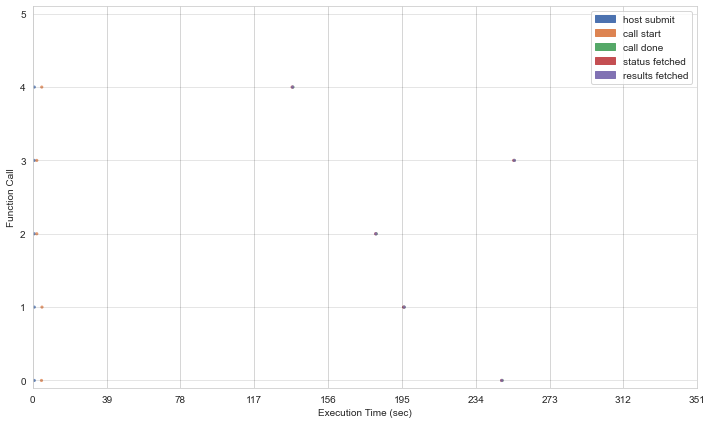

In [135]:
fexec.plot(dst="plots/scalability")

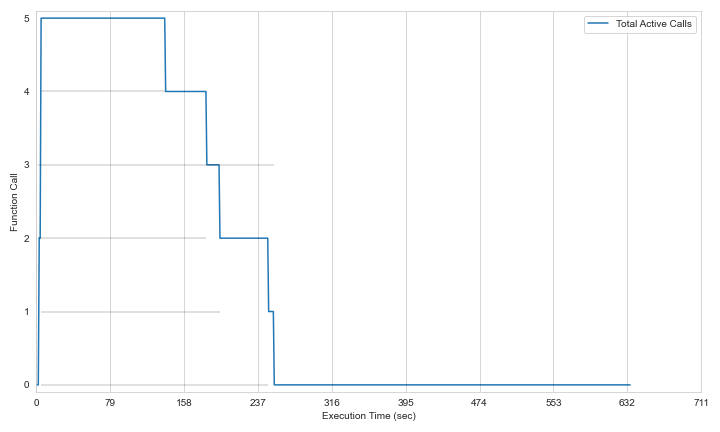

In [136]:
Image(filename="plots/scalability_histogram.png")

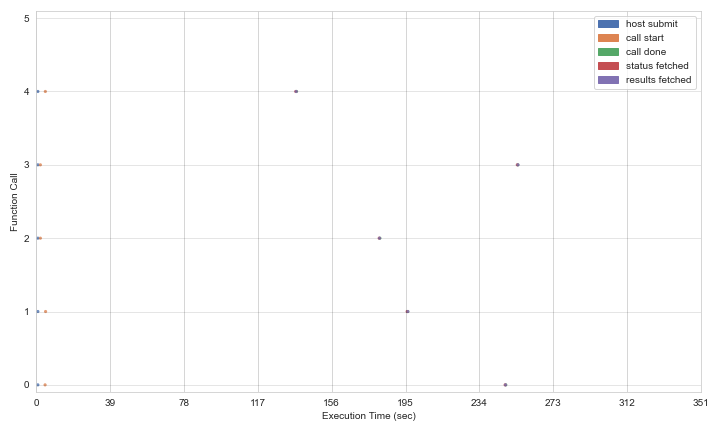

In [137]:
Image(filename="plots/scalability_timeline.png")

#### Cost "calculate_models"

In [138]:
fexec.job_summary()

2022-06-05 23:24:51,144 [INFO] lithops.executors -- View log file logs at C:\Users\saral\AppData\Local\Temp\lithops\logs\2022-06-05_23_24_51.csv


In [139]:
pd.read_csv(fexec.log_path)

,Job_ID,Function,Invocations,Memory(MB),AvgRuntime,Cost,CloudObjects
0,M000,calculate_models,5,10240,199.811185,0.033968,
1,Summary,,5,10240,199.811185,0.033968,0


In [140]:
cost_interpolation = get_process_cost(fexec)
print(f"The experiment cost of 'calculate_models' ${cost_interpolation:.4f}.")

The experiment cost of 'calculate_models' $0.0340.


#### Throughput

In [203]:
fexec = lithops.FunctionExecutor()
storage = Storage()

2022-06-05 23:53:22,469 [INFO] lithops.config -- Lithops v2.6.0
2022-06-05 23:53:22,488 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS client created - Region: eu-de
2022-06-05 23:53:22,490 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: eu-de - Namespace: my-geospatial-wildfirerisk_foundry-geospatial-wildfirerisk-0
2022-06-05 23:53:22,513 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS client created - Region: eu-de


##### Read

In [204]:
def storage_performance_read(key_name, storage):
    get_t0 = time.time()
    obj = storage.get_object(bucket=DATA_BUCKET, key=key_name)
    get_t1 = time.time()
    get_sz = len(key_name)
    read_bandwidth_mb = get_sz / (get_t1 - get_t0) / 1e6

    stats = {'t0': get_t0, 't1': get_t1, 'bandwidth': read_bandwidth_mb, 'size': get_sz}

    return stats

In [205]:
data_file_read = [str(obj['Key']) for obj in storage.list_objects(DATA_BUCKET) if str(obj['Key']).endswith('.laz')]

fexec = lithops.FunctionExecutor()
fs = fexec.map(storage_performance_read, data_file_read)
read_results = fexec.get_result(fs=fs)

2022-06-05 23:53:23,018 [INFO] lithops.config -- Lithops v2.6.0
2022-06-05 23:53:23,030 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS client created - Region: eu-de
2022-06-05 23:53:23,031 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: eu-de - Namespace: my-geospatial-wildfirerisk_foundry-geospatial-wildfirerisk-0
2022-06-05 23:53:23,034 [INFO] lithops.invokers -- ExecutorID bf7784-30 | JobID M000 - Selected Runtime: sararl27/lithops-ibm_cf-runtime-3.9:0.1 - 2048MB
2022-06-05 23:53:23,411 [INFO] lithops.invokers -- ExecutorID bf7784-30 | JobID M000 - Starting function invocation: storage_performance_read() - Total: 5 activations
2022-06-05 23:53:23,419 [INFO] lithops.invokers -- ExecutorID bf7784-30 | JobID M000 - View execution logs at C:\Users\saral\AppData\Local\Temp\lithops\logs\bf7784-30-M000.log
2022-06-05 23:53:23,422 [INFO] lithops.wait -- ExecutorID bf7784-30 - Getting results from 5 function activations


    0%|          | 0/5  

2022-06-05 23:53:29,873 [INFO] lithops.executors -- ExecutorID bf7784-30 - Cleaning temporary data


##### Write

In [206]:
def storage_performance_write(obj, size_file, storage): # Coje el fichero y lo sobre
    data = obj.data_stream.read()
    put_sz = size_file # Modified, get the size in bytes of the data to upload
    put_t0 = time.time()
    storage.put_object(bucket=DATA_BUCKET,  key=obj.key, body=data)
    put_t1 = time.time()
    write_bandwidth_mb = put_sz / (put_t1 - put_t0) / 1e6

    stats = {'t0': put_t0, 't1': put_t1, 'bandwidth': write_bandwidth_mb, 'size': put_sz}

    return stats

In [207]:
data_file_write = [{'obj':(f'cos://{DATA_BUCKET}/'+obj["Key"]), 'size_file': obj['Size']}
                   for obj in storage.list_objects(DATA_BUCKET) if str(obj['Key']).endswith('.tiff')]
fexec = lithops.FunctionExecutor()
fs = fexec.map(storage_performance_write, data_file_write)
write_results = fexec.get_result(fs=fs)

2022-06-05 23:53:30,086 [INFO] lithops.config -- Lithops v2.6.0
2022-06-05 23:53:30,109 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS client created - Region: eu-de
2022-06-05 23:53:30,117 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: eu-de - Namespace: my-geospatial-wildfirerisk_foundry-geospatial-wildfirerisk-0
2022-06-05 23:53:30,124 [INFO] lithops.invokers -- ExecutorID bf7784-31 | JobID M000 - Selected Runtime: sararl27/lithops-ibm_cf-runtime-3.9:0.1 - 2048MB
2022-06-05 23:53:30,903 [INFO] lithops.invokers -- ExecutorID bf7784-31 | JobID M000 - Starting function invocation: storage_performance_write() - Total: 20 activations
2022-06-05 23:53:30,997 [INFO] lithops.invokers -- ExecutorID bf7784-31 | JobID M000 - View execution logs at C:\Users\saral\AppData\Local\Temp\lithops\logs\bf7784-31-M000.log
2022-06-05 23:53:31,003 [INFO] lithops.wait -- ExecutorID bf7784-31 - Getting results from 20 function activations


    0%|          | 0/20  

2022-06-05 23:53:37,182 [INFO] lithops.executors -- ExecutorID bf7784-31 - Cleaning temporary data


#### Resume

In [208]:
def create_agg_bdwth_plot(res_write, res_read, dst):
    def compute_times_rates(start_time, d):
        x = np.array(d)
        tzero = start_time
        tr_start_time = x[:, 0] - tzero
        tr_end_time = x[:, 1] - tzero
        rate = x[:, 2]

        N = len(tr_start_time)
        runtime_rate_hist = np.zeros((N, len(runtime_bins)))

        for i in range(N):
            s = tr_start_time[i]
            e = tr_end_time[i]
            a, b = np.searchsorted(runtime_bins, [s, e])
            if b-a > 0:
                runtime_rate_hist[i, a:b] = rate[i]

        return {'start_time': tr_start_time,
                'end_time': tr_end_time,
                'rate': rate,
                'runtime_rate_hist': runtime_rate_hist}

    start_time = min((min(t['t0'] for t in res_write), (min(t['t0'] for t in res_read)))) - 1

    fig = pylab.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1)
    for datum, l in [(res_write, 'Aggregate Write Bandwidth'), (res_read, 'Aggregate Read Bandwidth')]:
        mb_rates = [(res['t0'], res['t1'], res['bandwidth']) for res in datum]
        max_seconds = int(max([mr[1]-start_time for mr in mb_rates])*1.2)
        max_seconds = 8 * round(max_seconds/8)
        runtime_bins = np.linspace(0, max_seconds, max_seconds)

        mb_rates_hist = compute_times_rates(start_time, mb_rates)

        ax.plot(mb_rates_hist['runtime_rate_hist'].sum(axis=0)/1000, label=l)

    ax.set_xlabel('Execution Time (sec)')
    ax.set_ylabel("GB/sec")
    ax.set_xlim(0, )
    ax.set_ylim(0, )
    pylab.legend()
    pylab.grid(True, axis='y')

    dst = os.path.expanduser(dst) if '~' in dst else dst
    fig.tight_layout()
    fig.savefig(dst, format='png')

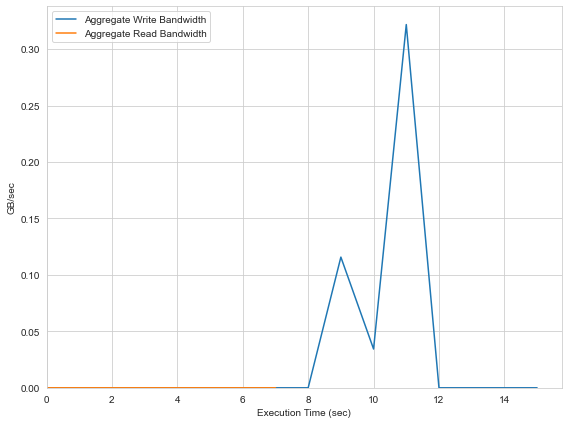

In [209]:
create_agg_bdwth_plot(write_results, read_results, './plots/throughput_storage_kpi.png')

In [222]:
def calc_mean_throughput(dict):
    res = 0
    for val in dict:
        res += val['bandwidth']
    return (res/len(dict))

In [224]:
print(f'Mean throughput read: {calc_mean_throughput(read_results)} MB/s')
print(f'Mean throughput write: {calc_mean_throughput(write_results)} MB/s')

Mean throughput read: 6.676473261344398e-05 MB/s
Mean throughput write: 39.01826904233151 MB/s


#### Cost throughput

In [212]:
fexec.job_summary()

2022-06-05 23:53:38,143 [INFO] lithops.executors -- View log file logs at C:\Users\saral\AppData\Local\Temp\lithops\logs\2022-06-05_23_53_38.csv


In [213]:
pd.read_csv(fexec.log_path)

,Job_ID,Function,Invocations,Memory(MB),AvgRuntime,Cost,CloudObjects
0,M000,storage_performance_write,20,40960,1.593972,0.001084,
1,Summary,,20,40960,1.593972,0.001084,0


In [214]:
cost_interpolation = get_process_cost(fexec)
print(f"The experiment cost of 'throughput' ${cost_interpolation:.4f}.")

The experiment cost of 'throughput' $0.0011.
